# Sample supervised segmentation on Gray images

Image  segmentation  is  widely  used  as  an  initial  phase  of  many  image  processing  tasks  in  computer vision and image analysis.  Many recent segmentation methods use superpixels, because they reduce the size of the segmentation problem by an order of magnitude.   In addition,  features on superpixels are much more robust than features  on  pixels  only.   We  use  spatial  regularization  on  superpixels  to  make  segmented  regions  more  compact. The segmentation pipeline comprises:  (i) computation of superpixels; (ii) extraction of descriptors such as color and texture;  (iii) soft classification,  using a standard classifier for supervised learning; (iv) final segmentation using Graph Cut.  We use this segmentation pipeline on four real-world applications in medical imaging. We also show that unsupervised segmentation is sufficient for some situations, and provides similar results to those obtained using trained segmentation.

Borovec, J., Svihlik, J., Kybic, J., & Habart, D. (2017). **Supervised and unsupervised segmentation using superpixels, model estimation, and Graph Cut.** Journal of Electronic Imaging.

In [1]:
%matplotlib inline
import os, sys, glob, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import imsegm.utilities.data_io as tl_data
import imsegm.pipelines as segm_pipe

## Load image

In [2]:
path_dir = os.path.join(tl_data.update_path('data_images'), 'drosophila_ovary_slice')
path_images = os.path.join(path_dir, 'image')
print ([os.path.basename(p) for p in glob.glob(os.path.join(path_images, '*.jpg'))])
# loading images
path_img = os.path.join(path_images, 'insitu7545.jpg')
img = np.array(Image.open(path_img))[:, :, 0]
path_img = os.path.join(path_images, 'insitu4174.jpg')
img2 = np.array(Image.open(path_img))[:, :, 0]
# loading annotations
path_annots = os.path.join(path_dir, 'annot_struct')
path_annot = os.path.join(path_annots, 'insitu7545.png')
annot = np.array(Image.open(path_annot))

['insitu7331.jpg', 'insitu4174.jpg', 'insitu4358.jpg', 'insitu7545.jpg', 'insitu7544.jpg']


Show that training example with annotation and testing image

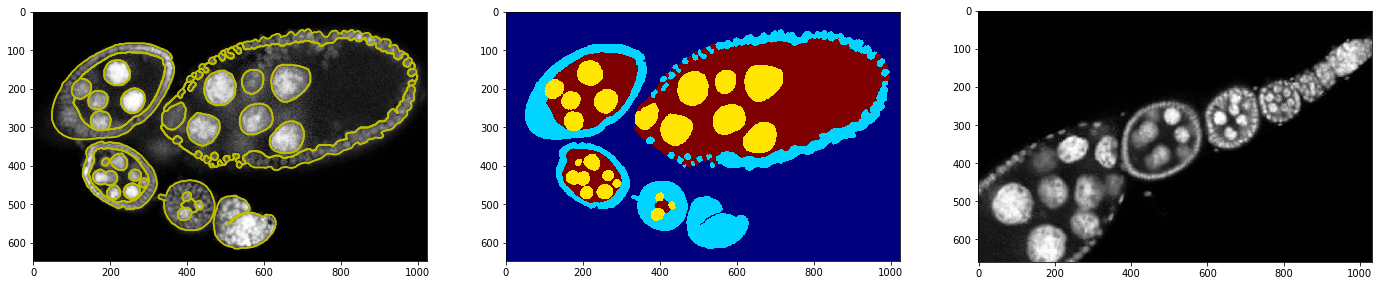

In [14]:
FIG_SIZE = (8. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]
fig = plt.figure(figsize=FIG_SIZE * 3)
_= plt.subplot(1,3,1), plt.imshow(img, cmap=plt.cm.Greys_r), plt.contour(annot, colors='y')
_= plt.subplot(1,3,2), plt.imshow(annot, cmap=plt.cm.jet)
_= plt.subplot(1,3,3), plt.imshow(img2, cmap=plt.cm.Greys_r)

## Segment Image

Set segmentation parameters:

In [4]:
sp_size = 25
sp_regul = 0.2
dict_features = {'color': ['mean', 'std', 'median'], 'tLM': ['mean']}

Train the classifier

In [5]:
classif, list_slic, list_features, list_labels = segm_pipe.train_classif_color2d_slic_features([img], [annot], 
             sp_size=sp_size, sp_regul=sp_regul, dict_features=dict_features, pca_coef=None)

Perform the segmentation with trained classifier

In [6]:
dict_debug = {}
seg, _ = segm_pipe.segment_color2d_slic_features_model_graphcut(img2, classif, sp_size=sp_size, sp_regul=sp_regul, 
                   gc_regul=1., dict_features=dict_features, gc_edge_type='model', debug_visual=dict_debug)

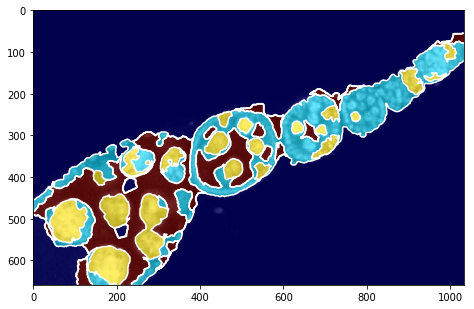

In [15]:
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(img2, cmap=plt.cm.Greys_r)
plt.imshow(seg, alpha=0.6, cmap=plt.cm.jet)
_= plt.contour(seg, levels=np.unique(seg), colors='w')

## Visualise intermediate steps

debug fields: dict_keys(['slic', 'img_graph_segm', 'slic_mean', 'segments', 'edge_weights', 'imgs_unary_cost', 'img_graph_edges', 'image', 'edges'])


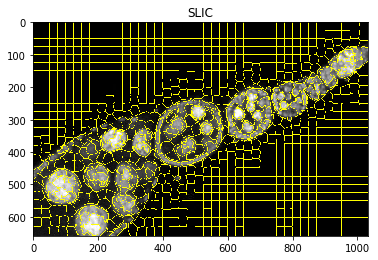

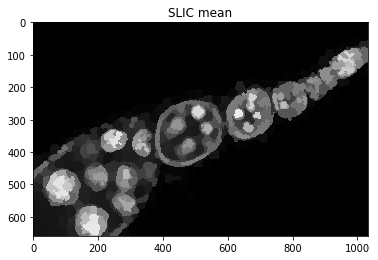

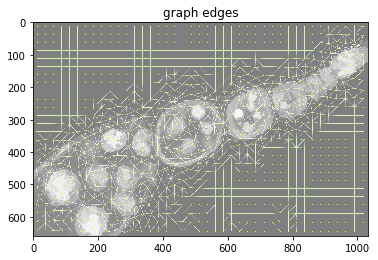

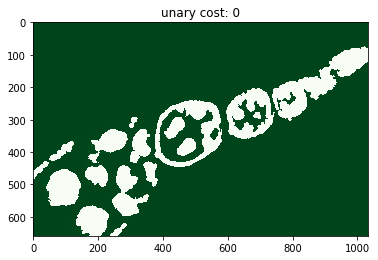

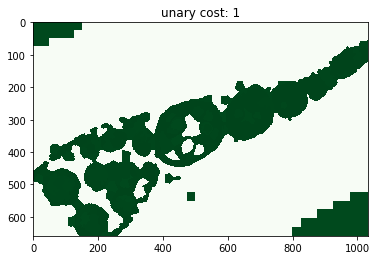

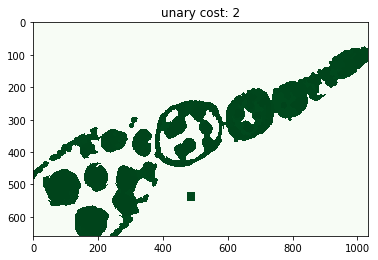

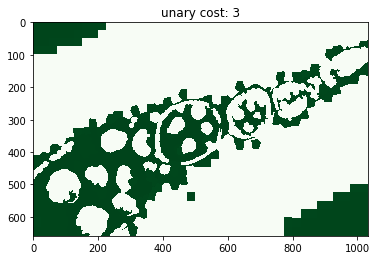

In [13]:
print ('debug fields: %s' % repr(dict_debug.keys()))
plt.figure(), plt.imshow(mark_boundaries(img2, dict_debug['slic'])), plt.title('SLIC')
plt.figure(), plt.imshow(dict_debug['slic_mean']), plt.title('SLIC mean')
plt.figure(), plt.imshow(dict_debug['img_graph_edges']), plt.title('graph edges')
for i, im_u in enumerate(dict_debug['imgs_unary_cost']):
    plt.figure(), plt.title('unary cost: %i' % i), plt.imshow(im_u)
# plt.figure(), plt.imshow(dict_debug['img_graph_segm'])